# start

In [45]:
import os
import pandas as pd
import numpy as np
import time
import glob
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
import dgl
import dgl.function as fn
import dgl.nn.pytorch as dgl_nn
import tensorflow as tf
import torch
import torch.nn as nn
from collections import defaultdict
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from rdkit.Chem.rdmolops import FastFindRings
from torch.nn import Parameter
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    

In [46]:
data_file = '../data2/data2.csv'
mol_dir = '../data2/data2_sdf_files/'

In [47]:
def Nodes_feat(mol):

    atom_feats_dict = defaultdict(list)
    is_donor = defaultdict(int)
    is_acceptor = defaultdict(int)
    
    
    fdef_name = os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef')
    mol.UpdatePropertyCache()
    FastFindRings(mol)
    mol_featurizer = ChemicalFeatures.BuildFeatureFactory(fdef_name)
    
    mol_feats = mol_featurizer.GetFeaturesForMol(mol)
    mol_conformers = mol.GetConformers()
       
    assert len(mol_conformers) == 1
    geom = mol_conformers[0].GetPositions()
    
    
    for i in range(len(mol_feats)):
        if mol_feats[i].GetFamily() == 'Donor':
            node_list = mol_feats[i].GetAtomIds()
            for u in node_list:
                is_donor[u] = 1
        elif mol_feats[i].GetFamily() == 'Acceptor':
            node_list = mol_feats[i].GetAtomIds()
            for u in node_list:
                is_acceptor[u] = 1
    
    num_atoms = mol.GetNumAtoms()
    
    atoms = mol.GetAtoms()
    AllChem.ComputeGasteigerCharges(mol)
    atom_types = [atom.GetAtomicNum() for atom in atoms]
    rdkit_period_table = Chem.GetPeriodicTable()
    radius = np.array([rdkit_period_table.GetRvdw(item) for item in atom_types])
    charge=[atom.GetDoubleProp('_GasteigerCharge') for atom in atoms]

    
    conformer = mol.GetConformer()
    positions = conformer.GetPositions()
    h_u = []    
    for u in range(num_atoms):
        ato = mol.GetAtomWithIdx(u)
        symbol = ato.GetSymbol()
        atom_type = ato.GetAtomicNum()
        aromatic = ato.GetIsAromatic()
        hybridization = ato.GetHybridization()
        #print(u)

        
        num_h = ato.GetTotalNumHs()#相连氢原子个数
        atom_feats_dict['pos'].append(torch.FloatTensor(geom[u]))
        atom_feats_dict['node_type'].append(atom_type)
       
       
        h_u += [
            int(symbol == x) for x in ['H', 'C', 'N', 'O', 'F', 'S', 'Cl']
        ]
        h_u.append(atom_type)
        h_u.append(is_acceptor[u])
        h_u.append(is_donor[u])
        h_u.append(int(aromatic))
        h_u += [
            int(hybridization == x)
            for x in (Chem.rdchem.HybridizationType.SP,
                      Chem.rdchem.HybridizationType.SP2,
                      Chem.rdchem.HybridizationType.SP3)
        ]
        h_u.append(num_h)
    h_u=np.array(h_u).reshape(-1,15)
    return h_u

In [48]:
def PackMat(arr_list):
    N = len(arr_list)
    M = max([np.array(arr_list[i]).shape[0] for i in range(len(arr_list))])
    pack_mat = np.zeros([N, M, 15])
    for i in range(N):
        for j in range(len(arr_list[i])):
            pack_mat[i, :len(arr_list[i]), :] = arr_list[i][j]
    return pack_mat

In [49]:
def sort_func(x): return eval(x.split('/')[-1].split('.')[0].split('_')[-1])
cat_files = sorted(glob.glob(mol_dir+'cat_*.sdf'),key=sort_func)
imine_files = sorted(glob.glob(mol_dir+'imine_*.sdf'),key=sort_func)
thiol_files = sorted(glob.glob(mol_dir+'thiol_*.sdf'),key=sort_func)

sdf_file=cat_files+imine_files+thiol_files
with open(mol_dir+'smiles_file_dict.csv','r') as fr:
    lines = fr.readlines()
smiles_name_dict = {tmp_line.strip().split(',')[0]:tmp_line.strip().split(',')[1] for tmp_line in lines}

In [50]:
def Calc_feat(file_list):
    
    all_atom_feats=[]
    feat_name_dict = {}
    for index, tmp_file in enumerate(file_list):
        tmp_fn = tmp_file.split('/')[-1].split('.')[0]
        feat_name_dict[tmp_fn] = index
        mol = Chem.MolFromMolFile(tmp_file,removeHs=False)
        num_atoms = mol.GetNumAtoms()
        print(tmp_file)
        atom_feats=[]
        for i in range(num_atoms):
            feat= Nodes_feat(mol)
            atom_feats.append(feat)
        all_atom_feats.append(atom_feats)
    all_atom_feats=np.array(all_atom_feats)
    all_atom_feats = PackMat(all_atom_feats)
    return all_atom_feats,feat_name_dict

In [13]:
imine_feat,imine_feat_name_dict=Calc_feat(imine_files)

../data2/data2_sdf_files/imine_0.sdf
../data2/data2_sdf_files/imine_1.sdf
../data2/data2_sdf_files/imine_2.sdf
../data2/data2_sdf_files/imine_3.sdf
../data2/data2_sdf_files/imine_4.sdf


In [14]:
cat_feat,cat_feat_name_dict=Calc_feat(cat_files)

../data2/data2_sdf_files/cat_0.sdf
../data2/data2_sdf_files/cat_1.sdf
../data2/data2_sdf_files/cat_2.sdf
../data2/data2_sdf_files/cat_3.sdf
../data2/data2_sdf_files/cat_4.sdf
../data2/data2_sdf_files/cat_5.sdf
../data2/data2_sdf_files/cat_6.sdf
../data2/data2_sdf_files/cat_7.sdf
../data2/data2_sdf_files/cat_8.sdf
../data2/data2_sdf_files/cat_9.sdf
../data2/data2_sdf_files/cat_10.sdf
../data2/data2_sdf_files/cat_11.sdf
../data2/data2_sdf_files/cat_12.sdf
../data2/data2_sdf_files/cat_13.sdf
../data2/data2_sdf_files/cat_14.sdf
../data2/data2_sdf_files/cat_15.sdf
../data2/data2_sdf_files/cat_16.sdf
../data2/data2_sdf_files/cat_17.sdf
../data2/data2_sdf_files/cat_18.sdf
../data2/data2_sdf_files/cat_19.sdf
../data2/data2_sdf_files/cat_20.sdf
../data2/data2_sdf_files/cat_21.sdf
../data2/data2_sdf_files/cat_22.sdf
../data2/data2_sdf_files/cat_23.sdf
../data2/data2_sdf_files/cat_24.sdf
../data2/data2_sdf_files/cat_25.sdf
../data2/data2_sdf_files/cat_26.sdf
../data2/data2_sdf_files/cat_27.sdf
..

In [15]:
thiol_feat,thiol_feat_name_dict=Calc_feat(thiol_files)

../data2/data2_sdf_files/thiol_0.sdf
../data2/data2_sdf_files/thiol_1.sdf
../data2/data2_sdf_files/thiol_2.sdf
../data2/data2_sdf_files/thiol_3.sdf
../data2/data2_sdf_files/thiol_4.sdf


In [51]:
tmp_df = pd.read_csv(data_file)
cat_smiles = tmp_df['Catalyst'].to_list()
imine_smiles = tmp_df['Imine'].to_list()
thiol_smiles = tmp_df['Thiol'].to_list()
labels = tmp_df['Output'].to_list()

In [52]:
total_cat_feat = np.array([cat_feat[cat_feat_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in cat_smiles])
total_imine_feat = np.array([imine_feat[imine_feat_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in imine_smiles])
total_thiol_feat = np.array([thiol_feat[thiol_feat_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in thiol_smiles])
np.save( '../data2/total_cat_feat.npy',total_cat_feat)
np.save( '../data2/total_imine_feat.npy',total_imine_feat)
np.save( '../data2/total_thiol_feat.npy',total_thiol_feat)

# load data

In [53]:
total_cat_feat=np.load( '../data2/total_cat_feat.npy')
total_imine_feat=np.load( '../data2/total_imine_feat.npy')
total_thiol_feat=np.load( '../data2/total_thiol_feat.npy')

In [19]:
total_cat_feat.shape,total_imine_feat.shape,total_thiol_feat.shape

((1075, 184, 15), (1075, 33, 15), (1075, 19, 15))

In [54]:
react_feat = np.concatenate([total_cat_feat,total_imine_feat,total_thiol_feat],axis=1)
labels_std = (np.array(labels)-np.min(labels))/(np.max(labels)-np.min(labels))

In [21]:
react_feat.shape,labels_std.shape

((1075, 236, 15), (1075,))

In [55]:
from tensorflow import keras
def z_score(arr):
    return (arr - tf.reduce_mean(arr))/tf.red(arr)
def max_min(arr):
    return (arr - np.min(arr))/(np.max(arr)-np.min(arr))
class SPMSNN(keras.Model):
    def __init__(self,cat_size,imine_size,thiol_size,hidden_size=256,depth=10,scaler_func=z_score):

        super(SPMSNN,self).__init__()
        self.cat_size = cat_size
        self.imine_size = imine_size
        self.thiol_size = thiol_size
        self.hidden_size = hidden_size
        self.depth = depth
        self.scaler_func = scaler_func
        self.norm_cat = keras.layers.BatchNormalization()
        self.norm_imine = keras.layers.BatchNormalization()
        self.norm_thiol = keras.layers.BatchNormalization()
        
        self.cat_feat_init_layer = keras.layers.Dense(hidden_size,
                                   kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                      use_bias=False
                                                     )
        self.cat_feat_hidden_layer = keras.layers.Dense(hidden_size,
                                     kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                        use_bias=False
                                                       )
        self.cat_feat_final_layer = keras.layers.Dense(1,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                       use_bias=False
                                                      )
        
        self.imine_feat_init_layer = keras.layers.Dense(hidden_size,
                                   kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                      use_bias=False
                                                     )
        self.imine_feat_hidden_layer = keras.layers.Dense(hidden_size,
                                     kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                        use_bias=False
                                                       )
        self.imine_feat_final_layer = keras.layers.Dense(1,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                       use_bias=False
                                                      )
        
        self.thiol_feat_init_layer = keras.layers.Dense(hidden_size,
                                     kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                        use_bias=False
                                                       )
        self.thiol_feat_hidden_layer = keras.layers.Dense(hidden_size,
                                       kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                          use_bias=False
                                                         )
        self.thiol_feat_final_layer = keras.layers.Dense(1,
                                      kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                         use_bias=False
                                                        )
        self.flatten = keras.layers.Flatten()
        self.fc_1 = keras.layers.Dense(256)
        self.fc_2 = keras.layers.Dense(256)
        self.fc_3 = keras.layers.Dense(1,activation='sigmoid')

    def call(self,input_):
        cat_x = input_[:,:self.cat_size,:]
        imine_x = input_[:,self.cat_size:self.cat_size+self.imine_size,:]
        thiol_x = input_[:,self.cat_size+self.imine_size:self.cat_size+self.imine_size+self.thiol_size,:]
        
        cat_x = self.cat_feat_init_layer(cat_x)
        for i in range(self.depth):
            cat_x = self.cat_feat_hidden_layer(cat_x)
            #cat_x = self.norm_cat(cat_x)
        #mean,variance = tf.nn.moments(cat_x,axes=None)
        #cat_x = (cat_x-mean)/variance
        cat_x = (cat_x - tf.reduce_min(cat_x))/(tf.reduce_max(cat_x)-tf.reduce_min(cat_x))
        cat_x = self.cat_feat_final_layer(cat_x)
        cat_x = self.norm_cat(cat_x)
        cat_x = tf.nn.tanh(cat_x)
        
        imine_x = self.imine_feat_init_layer(imine_x)
        for i in range(self.depth):
            imine_x = self.imine_feat_hidden_layer(imine_x)
            #imine_x = self.norm_imine(imine_x)
        #mean,variance = tf.nn.moments(imine_x,axes=None)
        #imine_x = (imine_x-mean)/variance
        imine_x = (imine_x - tf.reduce_min(imine_x))/(tf.reduce_max(imine_x)-tf.reduce_min(imine_x))
        imine_x = self.imine_feat_final_layer(imine_x)
        imine_x = self.norm_imine(imine_x)
        imine_x = tf.nn.tanh(imine_x)
        
        thiol_x = self.thiol_feat_init_layer(thiol_x)
        for i in range(self.depth):
            thiol_x = self.thiol_feat_hidden_layer(thiol_x)
            #thiol_x = self.norm_thiol(thiol_x)
        #mean,variance = tf.nn.moments(thiol_x,axes=None)
        #thiol_x = (thiol_x-mean)/variance
        thiol_x = (thiol_x - tf.reduce_min(thiol_x))/(tf.reduce_max(thiol_x)-tf.reduce_min(thiol_x))
        thiol_x = self.thiol_feat_final_layer(thiol_x)
        thiol_x = self.norm_thiol(thiol_x)
        thiol_x = tf.nn.tanh(thiol_x)        
        react_feat_mat = tf.concat([cat_x,imine_x,thiol_x],axis=1)        
        x = self.flatten(react_feat_mat)
        x = self.fc_3(self.fc_2(self.fc_1(x)))
        return x

# random

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error
#x_train, x_test, y_train, y_test = train_test_split(react_feat, labels_std, test_size=0.3, random_state=1000)


shuffle = np.array(list(range(len(react_feat))))
np.random.shuffle(shuffle)
train_index = shuffle[:600]
val_index = shuffle[600:]

x_train=react_feat[train_index]
y_train=labels_std[train_index]
x_test= react_feat[val_index]
y_test=labels_std[val_index]


In [58]:
from tensorflow.keras.callbacks import ModelCheckpoint
model = SPMSNN(total_cat_feat.shape[1],total_imine_feat.shape[1],total_thiol_feat.shape[1],depth=4,hidden_size=15)
opt = tf.keras.optimizers.Adam()
model.compile(
    optimizer=opt,
    loss='mse')

checkpoint=ModelCheckpoint("./dataset/run_data/denmark_graph_random_baseline.hdf5",
                               verbose=0,monitor='val_loss',
                               save_best_only=True,mode='min')


history = model.fit(x=x_train,y=y_train,validation_data=(x_test,y_test),batch_size=128,epochs=200,callbacks=[checkpoint])

Epoch 1/200
1/5 [=====>........................] - ETA: 10s - loss: 0.0339

NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.

In [104]:
new_model = SPMSNN(total_cat_feat.shape[1],total_imine_feat.shape[1],total_thiol_feat.shape[1],depth=4,hidden_size=15)
new_model.compile(optimizer=opt,loss='mse')
_ = new_model.fit(x=x_train,y=y_train,validation_data=(x_test,y_test),epochs=1)
new_model.load_weights("./Denmark_DataSet/denmark_graph_random_baseline.hdf5")

19/19 [==============================] - 1s 18ms/step - loss: 0.2212 - val_loss: 0.0997


In [106]:
np.save( './Denmark_DataSet/denmark_graph_random_y_test_for_draw.npy',y_test_for_draw)
np.save( './Denmark_DataSet/denmark_graph_random_y_test_pred_for_draw.npy',y_test_pred_for_draw)

In [43]:
y_test_for_draw=np.load( './Denmark_DataSet/denmark_graph_random_y_test_for_draw.npy')
y_test_pred_for_draw=np.load( './Denmark_DataSet/denmark_graph_random_y_test_pred_for_draw.npy')

FileNotFoundError: [Errno 2] No such file or directory: './Denmark_DataSet/denmark_graph_random_y_test_for_draw.npy'

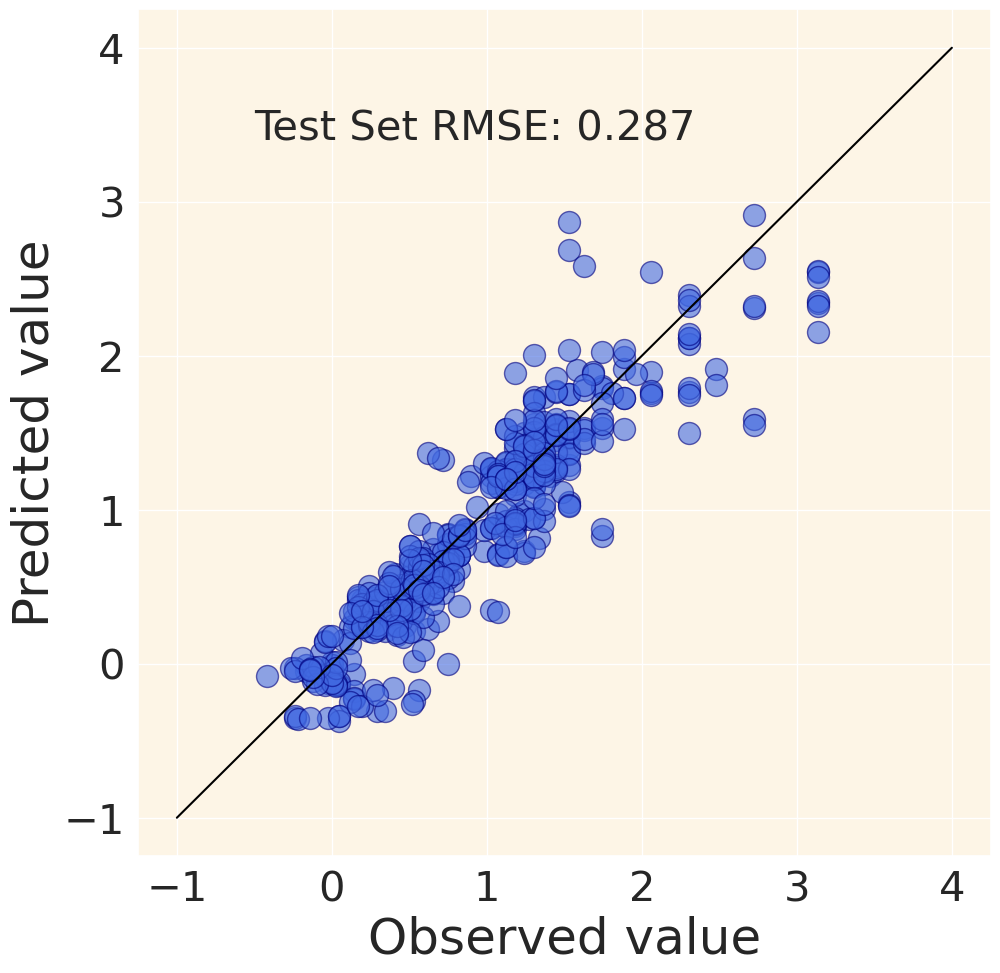

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
sns.set(style='darkgrid')
y_test_pre=new_model.predict(x_test)
y_test_for_draw = y_test*(np.max(labels)-np.min(labels))+np.min(labels)
y_test_pred_for_draw = y_test_pre*(np.max(labels)-np.min(labels))+np.min(labels)

#display.set_matplotlib_formats('svg')
fig = plt.figure(figsize=(11,11),facecolor='white',    # 图表区的背景色
           edgecolor='black')
#plt.scatter(y_train_for_draw,y_train_pred_for_draw,s=20, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')
plt.scatter(y_test_for_draw,y_test_pred_for_draw,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')
plt.plot([-1,4],[-1,4],c='black')
'''x = np.arange(-1,5)
y = x
l = plt.plot(x,y)
plt.xlim(-1,4)
plt.ylim(-1,4)
plt.fill_between(x,x+0.5,x-0.5,alpha=0.2,color='yellow')'''
#plt.title('doyle',fontsize=14)
ax=plt.gca()
ax.set_facecolor('oldlace')#oldlace   mistyrose
plt.xlabel("Observed value",fontsize=36)
plt.ylabel("Predicted value",fontsize=36)

#plt.grid(c='blue',linewidth=2)

plt.tick_params(labelsize=30)
plt.text(-0.5,3.4,'Test Set RMSE: %.3f'%(mean_squared_error(y_test_for_draw,y_test_pred_for_draw))**(0.5),fontsize=30)
plt.show()
#plt.text(-0.5,3.4,'Test Set R2: %.3f'%r2_score(y_test_for_draw,y_test_pred_for_draw),fontsize=24)
fig.savefig('./denmark_random_fig.png',dpi=400)

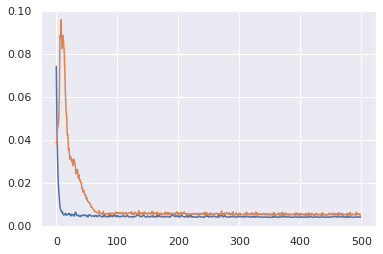

In [59]:
import matplotlib.pyplot as plt
plt.plot(range(len(history.history['loss'])),history.history['loss'])
plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'])

# low_hight

In [22]:
labels=np.array(labels)
ee = np.round((np.exp(labels*4184/(8.314*298.15)) - 1)/(np.exp(labels*4184/(8.314*298.15))+1),decimals=2)
low_data_index = np.where((ee<0.8))[0]
high_data_index = np.where((ee>=0.8))[0]
shuffle = list(range(len(high_data_index)))
np.random.shuffle(shuffle)
test_index = high_data_index[shuffle]
x_train=react_feat[low_data_index]
y_train=labels_std[low_data_index]
x_test= react_feat[test_index]
y_test=labels_std[test_index]

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint
model = SPMSNN(total_cat_feat.shape[1],total_imine_feat.shape[1],total_thiol_feat.shape[1],depth=3,hidden_size=15)
opt = tf.keras.optimizers.Adam()
model.compile(
    optimizer=opt,
    loss='mse')

checkpoint=ModelCheckpoint("./Denmark_DataSet/denmark_graph_random_baseline.hdf5",
                               verbose=0,monitor='loss',
                               save_best_only=True,mode='min')


history = model.fit(x=x_train,y=y_train,validation_data=(x_test,y_test),batch_size=64,epochs=200,callbacks=[checkpoint])

Epoch 1/200
12/12 [==============================] - 1s 26ms/step - loss: 0.0465 - val_loss: 0.0441
Epoch 2/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0165 - val_loss: 0.0270
Epoch 3/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0128 - val_loss: 0.0222
Epoch 4/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0110 - val_loss: 0.0226
Epoch 5/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0090 - val_loss: 0.0222
Epoch 6/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0066 - val_loss: 0.0224
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 0.0074 - val_loss: 0.0226
Epoch 8/200
12/12 [==============================] - 0s 5ms/step - loss: 0.0052 - val_loss: 0.0228
Epoch 9/200
12/12 [==============================] - 0s 5ms/step - loss: 0.0044 - val_loss: 0.0233
Epoch 10/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0226
Epoch 11

12/12 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0168
Epoch 84/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0206
Epoch 85/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0210
Epoch 86/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0147
Epoch 87/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0154
Epoch 88/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0193
Epoch 89/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0217
Epoch 90/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0322
Epoch 91/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0178
Epoch 92/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0226
Epoch 93/200


In [47]:
np.min(history.history['val_loss'])

0.011455167084932327

In [36]:
new_model = SPMSNN(total_cat_feat.shape[1],total_imine_feat.shape[1],total_thiol_feat.shape[1],depth=3,hidden_size=15)
new_model.compile(optimizer=opt,loss='mse')
_ = new_model.fit(x=x_train,y=y_train,validation_data=(x_test,y_test),epochs=1)
new_model.load_weights("./Denmark_DataSet/denmark_graph_random_baseline.hdf5")
y_test_pre=new_model.predict(x_test)
y_test_for_draw = y_test*(np.max(labels)-np.min(labels))+np.min(labels)
y_test_pred_for_draw = y_test_pre*(np.max(labels)-np.min(labels))+np.min(labels)
y_train_for_draw=y_train*(np.max(labels)-np.min(labels))+np.min(labels)
y_train_pred_for_draw=new_model.predict(x_train)*(np.max(labels)-np.min(labels))+np.min(labels)

23/23 [==============================] - 1s 22ms/step - loss: 0.0909 - val_loss: 0.3900


In [51]:
np.save( './Denmark_DataSet/denmark_graph_low_y_test_for_draw.npy',y_test_for_draw)
np.save( './Denmark_DataSet/denmark_graph_low_y_test_pred_for_draw.npy',y_test_pred_for_draw)
np.save( './Denmark_DataSet/denmark_graph_low_y_train_for_draw.npy',y_train_for_draw)
np.save( './Denmark_DataSet/denmark_graph_low_y_train_pred_for_draw.npy',y_train_pred_for_draw)

In [142]:
y_test_for_draw=np.load( './Denmark_DataSet/denmark_graph_low_y_test_for_draw.npy')
y_test_pred_for_draw=np.load( './Denmark_DataSet/denmark_graph_low_y_test_pred_for_draw.npy')
y_train_for_draw=np.load( './Denmark_DataSet/denmark_graph_low_y_train_for_draw.npy')
y_train_pred_for_draw=np.load( './Denmark_DataSet/denmark_graph_low_y_train_pred_for_draw.npy')

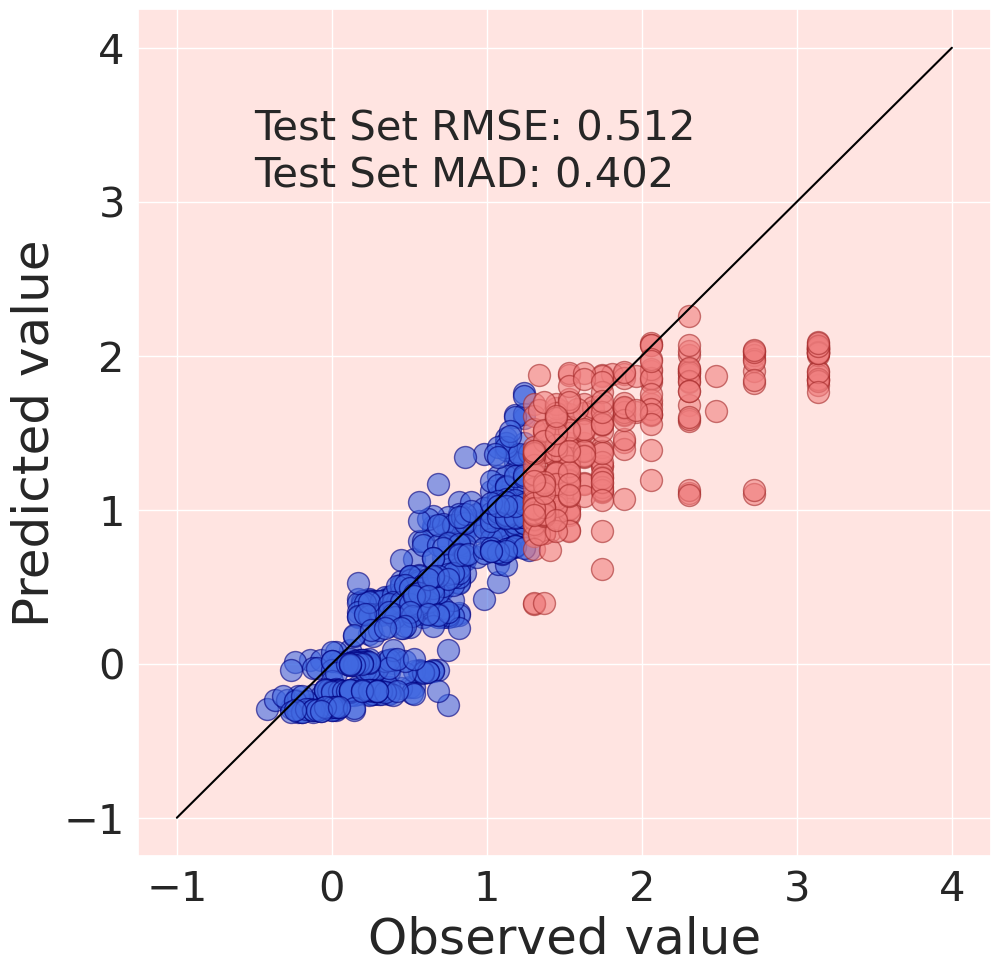

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
sns.set(style='darkgrid')


#display.set_matplotlib_formats('svg')
fig = plt.figure(figsize=(11,11),facecolor='white',    # 图表区的背景色
           edgecolor='black')
plt.scatter(y_train_for_draw,y_train_pred_for_draw,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')
plt.scatter(y_test_for_draw,y_test_pred_for_draw,s=250, c='lightcoral', label="samples",alpha=0.6,edgecolors='brown')
plt.plot([-1,4],[-1,4],c='black')
'''x = np.arange(-1,5)
y = x
l = plt.plot(x,y)
plt.xlim(-1,4)
plt.ylim(-1,4)
plt.fill_between(x,x+0.5,x-0.5,alpha=0.2,color='yellow')'''
#plt.title('doyle',fontsize=14)
ax=plt.gca()
ax.set_facecolor('mistyrose')#oldlace   mistyrose
plt.xlabel("Observed value",fontsize=36)
plt.ylabel("Predicted value",fontsize=36)

#plt.grid(c='blue',linewidth=2)

plt.tick_params(labelsize=30)
plt.text(-0.5,3.4,'Test Set RMSE: %.3f'%(mean_squared_error(y_test_for_draw,y_test_pred_for_draw))**(0.5),fontsize=30)
plt.text(-0.5,3.1,'Test Set MAD: %.3f'%(mean_absolute_error(y_test_for_draw,y_test_pred_for_draw)),fontsize=30)
plt.show()
#plt.text(-0.5,3.4,'Test Set R2: %.3f'%r2_score(y_test_for_draw,y_test_pred_for_draw),fontsize=24)
fig.savefig('./denmark_random_fig.png',dpi=400)

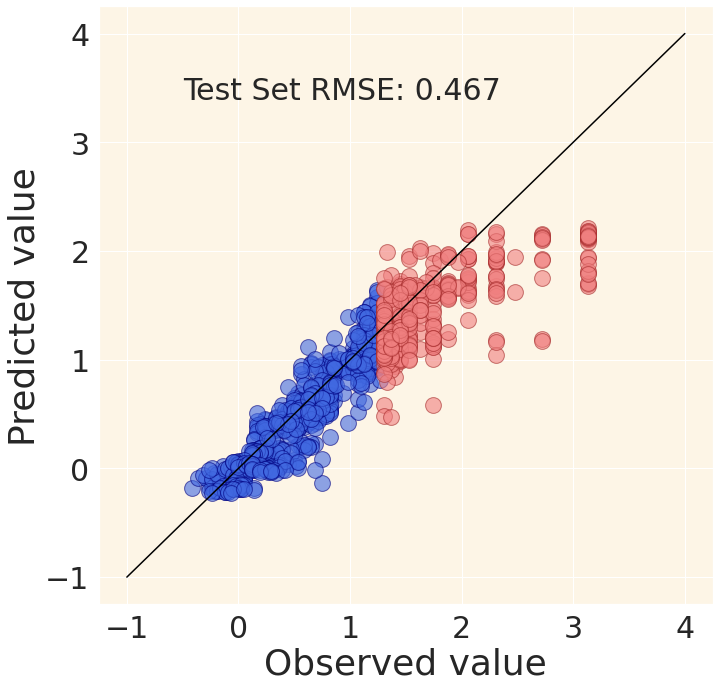

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
sns.set(style='darkgrid')


#display.set_matplotlib_formats('svg')
fig = plt.figure(figsize=(11,11),facecolor='white',    # 图表区的背景色
           edgecolor='black')
plt.scatter(y_train_for_draw,y_train_pred_for_draw,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')
plt.scatter(y_test_for_draw,y_test_pred_for_draw,s=250, c='lightcoral', label="samples",alpha=0.6,edgecolors='brown')
plt.plot([-1,4],[-1,4],c='black')
'''x = np.arange(-1,5)
y = x
l = plt.plot(x,y)
plt.xlim(-1,4)
plt.ylim(-1,4)
plt.fill_between(x,x+0.5,x-0.5,alpha=0.2,color='yellow')'''
#plt.title('doyle',fontsize=14)
ax=plt.gca()
ax.set_facecolor('oldlace')#oldlace   mistyrose
plt.xlabel("Observed value",fontsize=36)
plt.ylabel("Predicted value",fontsize=36)

#plt.grid(c='blue',linewidth=2)

plt.tick_params(labelsize=30)
plt.text(-0.5,3.4,'Test Set RMSE: %.3f'%(mean_squared_error(y_test_for_draw,y_test_pred_for_draw))**(0.5),fontsize=30)
#plt.text(-0.5,3.4,'Test Set R2: %.3f'%r2_score(y_test_for_draw,y_test_pred_for_draw),fontsize=24)
fig.savefig('./denmark_random_fig.png',dpi=400)

# mul_attention

In [59]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Multiply,LSTM
import tensorflow
batch_size=32
def z_score(arr):
    return (arr - tf.reduce_mean(arr))/tf.red(arr)
def max_min(arr):
    return (arr - np.min(arr))/(np.max(arr)-np.min(arr))
class SPMSElecMulAttentionNN(keras.Model):
    def __init__(self,cat_size=184,imine_size=33,thiol_size=19,hidden_size=256,depth=10,attention_depth=4
                 ,scaler_func=z_score,attention_depth_inter=1,inter_len=8,end_attention=1,fc_size=256 ):
        #attention_depth=4,attention_depth_inter=1,inter_len=8,end_attention=1,final_act='sigmoid'    
        super(SPMSElecMulAttentionNN,self).__init__()
        self.cat_size = cat_size
        self.imine_size = imine_size
        self.thiol_size = thiol_size
        self.hidden_size = hidden_size
        self.fc_size=fc_size
        self.depth = depth
        self.attention_depth=attention_depth
        self.scaler_func = scaler_func
        self.norm_cat = keras.layers.BatchNormalization()
        self.norm_imine = keras.layers.BatchNormalization()
        self.norm_thiol = keras.layers.BatchNormalization()

        self.inter_len=inter_len
        self.attention_depth=attention_depth
        self.end_attention=end_attention
        self.attention_depth_inter=attention_depth_inter
        
        self.cat_feat_init_layer = keras.layers.Dense(hidden_size,
                                   kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                      use_bias=False
                                                     )
        self.cat_feat_hidden_layer = keras.layers.Dense(hidden_size,
                                     kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                        use_bias=False
                                                       )
        self.cat_feat_final_layer = keras.layers.Dense(1,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                       use_bias=False
                                                      )
        self.cat_feat_attention_dense = Dense(cat_size, activation='softmax', name='attention_vec')
        self.cat_feat_attention_mul =  Multiply()
        
        self.imine_feat_init_layer = keras.layers.Dense(hidden_size,
                                   kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                      use_bias=False
                                                     )
        self.imine_feat_hidden_layer = keras.layers.Dense(hidden_size,
                                     kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                        use_bias=False
                                                       )
        self.imine_feat_final_layer = keras.layers.Dense(1,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                       use_bias=False
                                                      )
        self.imine_feat_attention_dense = Dense(imine_size, activation='softmax', name='attention_vec')
        self.imine_feat_attention_mul =  Multiply()
        
        self.thiol_feat_init_layer = keras.layers.Dense(hidden_size,
                                     kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                        use_bias=False
                                                       )
        self.thiol_feat_hidden_layer = keras.layers.Dense(hidden_size,
                                       kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                          use_bias=False
                                                         )
        self.thiol_feat_final_layer = keras.layers.Dense(1,
                                      kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                                                         use_bias=False
                                                        )
        self.thiol_feat_attention_dense = Dense(thiol_size, activation='softmax', name='attention_vec')
        self.thiol_feat_attention_mul =  Multiply()
        
        self.flatten = keras.layers.Flatten()
        self.fc_1 = keras.layers.Dense(128)
        self.fc_2 = keras.layers.Dense(128)
        self.fc_3 = keras.layers.Dense(1,activation='sigmoid')
        self.fc_5 = keras.layers.Dense(32)
        
        
        self.feat_number=32
        self.super_feat_attention_dense = Dense(self.feat_number, activation='softmax', name='attention_vec')
        self.super_feat_attention_mul =  Multiply() 
        
        self.conv2d_3 = keras.layers.Conv2D(1,(16,16))
        self.conv2d_4 = keras.layers.Conv2D(1,(8,8))
        self.conv2d_5 = keras.layers.Conv2D(1,(inter_len,inter_len))
        self.x_attention_dense = Dense(245, activation='softmax', name='attention_vec')
        self.x_attention_mul =  Multiply()        
    def call(self,input_):
        number_batch=len(input_)
        cat_x = input_[:,:self.cat_size,:]
        imine_x = input_[:,self.cat_size:self.cat_size+self.imine_size,:]
        thiol_x = input_[:,self.cat_size+self.imine_size:self.cat_size+self.imine_size+self.thiol_size,:]
        
        cat_x=tf.reshape(cat_x,[-1,15,self.cat_size])
        imine_x=tf.reshape(imine_x,[-1,15,self.imine_size])        
        thiol_x=tf.reshape(thiol_x,[-1,15,self.thiol_size])        
        for i in range(self.attention_depth):
            cat_x_=self.cat_feat_attention_dense(cat_x)
            cat_x=self.cat_feat_attention_mul([cat_x,cat_x_])    
            imine_x_=self.imine_feat_attention_dense(imine_x)
            imine_x=self.imine_feat_attention_mul([imine_x,imine_x_])  
            thiol_x_=self.thiol_feat_attention_dense(thiol_x)
            thiol_x=self.thiol_feat_attention_mul([thiol_x,thiol_x_])         
        cat_x=tf.reshape(cat_x,[-1,self.cat_size,15])
        imine_x=tf.reshape(imine_x,[-1,self.imine_size,15])        
        thiol_x=tf.reshape(thiol_x,[-1,self.thiol_size,15])         
        
        cat_x = self.cat_feat_init_layer(cat_x)
        for i in range(self.depth):
            cat_x = self.cat_feat_hidden_layer(cat_x)
            #cat_x = self.norm_cat(cat_x)
        #mean,variance = tf.nn.moments(cat_x,axes=None)
        #cat_x = (cat_x-mean)/variance
        cat_x = (cat_x - tf.reduce_min(cat_x))/(tf.reduce_max(cat_x)-tf.reduce_min(cat_x))
        cat_x = self.cat_feat_final_layer(cat_x)
        cat_x = self.norm_cat(cat_x)
        cat_x = tf.nn.tanh(cat_x)
        
        imine_x = self.imine_feat_init_layer(imine_x)
        for i in range(self.depth):
            imine_x = self.imine_feat_hidden_layer(imine_x)
            #imine_x = self.norm_imine(imine_x)
        #mean,variance = tf.nn.moments(imine_x,axes=None)
        #imine_x = (imine_x-mean)/variance
        imine_x = (imine_x - tf.reduce_min(imine_x))/(tf.reduce_max(imine_x)-tf.reduce_min(imine_x))
        imine_x = self.imine_feat_final_layer(imine_x)
        imine_x = self.norm_imine(imine_x)
        imine_x = tf.nn.tanh(imine_x)
        
        thiol_x = self.thiol_feat_init_layer(thiol_x)
        for i in range(self.depth):
            thiol_x = self.thiol_feat_hidden_layer(thiol_x)
            #thiol_x = self.norm_thiol(thiol_x)
        #mean,variance = tf.nn.moments(thiol_x,axes=None)
        #thiol_x = (thiol_x-mean)/variance
        thiol_x = (thiol_x - tf.reduce_min(thiol_x))/(tf.reduce_max(thiol_x)-tf.reduce_min(thiol_x))
        thiol_x = self.thiol_feat_final_layer(thiol_x)
        thiol_x = self.norm_thiol(thiol_x)
        thiol_x = tf.nn.tanh(thiol_x)
        react_feat_mat = tf.concat([cat_x,imine_x,thiol_x],axis=1)
        
        
        
        print('react_feat_mat',react_feat_mat.shape)
        react_feat_mat=tf.reshape(react_feat_mat,[number_batch,236])
        print('react_feat_mat',react_feat_mat.shape)
        react_feat_mat_=react_feat_mat
        react_feat_mat=self.fc_5(react_feat_mat)
        print('react_feat_mat',react_feat_mat.shape)
        
        super_feat=tf.reshape(react_feat_mat,[number_batch,1,self.feat_number])
        print('super_feat',super_feat.shape)
        #print('1super_spms shape',super_spms.shape)
        #print('1super_ele shape',super_ele.shape)
        for i in range(self.attention_depth_inter):
            super_feat_=self.super_feat_attention_dense(super_feat)
            super_feat=self.super_feat_attention_mul([super_feat,super_feat_])    

        #print('2super_spms shape',super_spms.shape)
        #print('2super_ele shape',super_ele.shape)
        
        react_feat_mat=tf.matmul(tf.reshape(react_feat_mat,[number_batch,self.feat_number,1]),super_feat)
        react_feat_mat=tf.reshape(react_feat_mat,[number_batch,self.feat_number,self.feat_number,1])
        react_feat_mat=self.flatten(self.conv2d_5(self.conv2d_4(self.conv2d_3(react_feat_mat))))
        react_feat_mat=tf.reshape(react_feat_mat,[number_batch,-1])
        #print('react_spms_x shape',react_spms_x.shape)
        print('react_feat_mat',react_feat_mat.shape)
        print('react_feat_mat_',react_feat_mat_.shape)

        #print('react_elec_x shape',react_elec_x.shape)
        
        x = tf.concat([react_feat_mat_,react_feat_mat],axis=1)
        print('attention need',x.shape)
        x=tf.reshape(x,[number_batch,245])
        for i in range(self.end_attention):
            x_=self.x_attention_dense(x)
            x=self.x_attention_mul([x,x_])          
        
        
        #x = self.flatten(x)
        #x = self.fc_3(x)
        x = self.fc_3(self.fc_2(self.fc_1(x)))
        return x

## random

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error
#x_train, x_test, y_train, y_test = train_test_split(react_feat, labels_std, test_size=0.3, random_state=1000)


shuffle = np.array(list(range(len(react_feat))))
np.random.shuffle(shuffle)
train_index = shuffle[:600]
val_index = shuffle[600:]

x_train=react_feat[train_index]
y_train=labels_std[train_index]
x_test= react_feat[val_index]
y_test=labels_std[val_index]

In [61]:
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
model = SPMSElecMulAttentionNN(184, 33, 19,depth=6,attention_depth=1,attention_depth_inter=1,inter_len=8,end_attention=1,hidden_size=15)
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,loss='mse')
checkpoint = tf.train.Checkpoint(myAwesomeModel=model)
EPOCHS = 50
for epoch in range(EPOCHS):
    
    hist = model.fit(x=x_train,y=y_train,validation_data=(x_test,y_test),batch_size=32)
    #predict=model.predict(x_test)
    #print(mean_squared_error(y_test,predict))
    path = checkpoint.save('./Denmark_DataSet/run_data/denmark_mulattention_random_basemodel.ckpt')
    print("model saved to %s" % path)
    

react_feat_mat (None, 236, 1)
react_feat_mat (None, 236)
react_feat_mat (None, 32)
super_feat (None, 1, 32)
react_feat_mat (None, None)
react_feat_mat_ (None, 236)
attention need (None, None)
react_feat_mat (None, 236, 1)
react_feat_mat (None, 236)
react_feat_mat (None, 32)
super_feat (None, 1, 32)
react_feat_mat (None, None)
react_feat_mat_ (None, 236)
attention need (None, None)
15/19 [======================>.......] - ETA: 0s - loss: 0.0419react_feat_mat (None, 236, 1)
react_feat_mat (None, 236)
react_feat_mat (None, 32)
super_feat (None, 1, 32)
react_feat_mat (None, None)
react_feat_mat_ (None, 236)
attention need (None, None)
19/19 [==============================] - 3s 39ms/step - loss: 0.0415 - val_loss: 0.0391
model saved to ./Denmark_DataSet/run_data/denmark_mulattention_random_basemodel.ckpt-1
19/19 [==============================] - 0s 12ms/step - loss: 0.0386 - val_loss: 0.0389
model saved to ./Denmark_DataSet/run_data/denmark_mulattention_random_basemodel.ckpt-2
19/19 [====

19/19 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0056
model saved to ./Denmark_DataSet/run_data/denmark_mulattention_random_basemodel.ckpt-44
19/19 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0053
model saved to ./Denmark_DataSet/run_data/denmark_mulattention_random_basemodel.ckpt-45
19/19 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0058
model saved to ./Denmark_DataSet/run_data/denmark_mulattention_random_basemodel.ckpt-46
19/19 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0049
model saved to ./Denmark_DataSet/run_data/denmark_mulattention_random_basemodel.ckpt-47
19/19 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0053
model saved to ./Denmark_DataSet/run_data/denmark_mulattention_random_basemodel.ckpt-48
19/19 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0058
model saved to ./Denmark_DataSet

19/19 [==============================] - 0s 11ms/step - loss: 7.3147e-04 - val_loss: 0.0061
model saved to ./Denmark_DataSet/run_data/denmark_mulattention_random_basemodel.ckpt-90
19/19 [==============================] - 0s 11ms/step - loss: 6.5897e-04 - val_loss: 0.0061
model saved to ./Denmark_DataSet/run_data/denmark_mulattention_random_basemodel.ckpt-91
19/19 [==============================] - 0s 11ms/step - loss: 5.9684e-04 - val_loss: 0.0063
model saved to ./Denmark_DataSet/run_data/denmark_mulattention_random_basemodel.ckpt-92
19/19 [==============================] - 0s 10ms/step - loss: 6.2433e-04 - val_loss: 0.0056
model saved to ./Denmark_DataSet/run_data/denmark_mulattention_random_basemodel.ckpt-93
19/19 [==============================] - 0s 11ms/step - loss: 4.7452e-04 - val_loss: 0.0067
model saved to ./Denmark_DataSet/run_data/denmark_mulattention_random_basemodel.ckpt-94
19/19 [==============================] - 0s 10ms/step - loss: 4.7148e-04 - val_loss: 0.0062
model sa

In [73]:
all_rmse=[]
all_r2=[]
all_test_=[]
all_pred_=[]
for m in list(range(80,90)):    
    opt = tf.keras.optimizers.Adam()
    new_model =SPMSElecMulAttentionNN(184, 33, 19,depth=6,attention_depth=1,attention_depth_inter=1,inter_len=8,end_attention=1,hidden_size=15)
    new_model.compile(optimizer=opt,loss='mse')
    _ = new_model.fit(x=x_train,y=y_train,validation_data=(x_test,y_test),epochs=1)
    checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
    checkpoint.restore('./Denmark_DataSet/run_data/denmark_mulattention_random_basemodel.ckpt-%d'%m)

    y_test_pre=new_model.predict(x_test)
    y_val = y_test*(np.max(labels)-np.min(labels))+np.min(labels)
    y_pred = y_test_pre*(np.max(labels)-np.min(labels))+np.min(labels)
    rmse=np.round((mean_squared_error(y_val,y_pred))**(0.5),3)
    r2=np.round(r2_score(y_val,y_pred),3)
    all_rmse.append(rmse)
    all_r2.append(r2)
    print('-----------------------------',m,rmse,r2,'-----------------------------')

react_feat_mat (None, 236, 1)
react_feat_mat (None, 236)
react_feat_mat (None, 32)
super_feat (None, 1, 32)
react_feat_mat (None, None)
react_feat_mat_ (None, 236)
attention need (None, None)
react_feat_mat (None, 236, 1)
react_feat_mat (None, 236)
react_feat_mat (None, 32)
super_feat (None, 1, 32)
react_feat_mat (None, None)
react_feat_mat_ (None, 236)
attention need (None, None)
16/19 [========================>.....] - ETA: 0s - loss: 0.0409react_feat_mat (None, 236, 1)
react_feat_mat (None, 236)
react_feat_mat (None, 32)
super_feat (None, 1, 32)
react_feat_mat (None, None)
react_feat_mat_ (None, 236)
attention need (None, None)
19/19 [==============================] - 2s 35ms/step - loss: 0.0411 - val_loss: 0.0390
react_feat_mat (None, 236, 1)
react_feat_mat (None, 236)
react_feat_mat (None, 32)
super_feat (None, 1, 32)
react_feat_mat (None, None)
react_feat_mat_ (None, 236)
attention need (None, None)
----------------------------- 80 0.277 0.843 -----------------------------
react_

17/19 [=========================>....] - ETA: 0s - loss: 0.0404react_feat_mat (None, 236, 1)
react_feat_mat (None, 236)
react_feat_mat (None, 32)
super_feat (None, 1, 32)
react_feat_mat (None, None)
react_feat_mat_ (None, 236)
attention need (None, None)
19/19 [==============================] - 2s 35ms/step - loss: 0.0424 - val_loss: 0.0390
react_feat_mat (None, 236, 1)
react_feat_mat (None, 236)
react_feat_mat (None, 32)
super_feat (None, 1, 32)
react_feat_mat (None, None)
react_feat_mat_ (None, 236)
attention need (None, None)
----------------------------- 88 0.273 0.848 -----------------------------
react_feat_mat (None, 236, 1)
react_feat_mat (None, 236)
react_feat_mat (None, 32)
super_feat (None, 1, 32)
react_feat_mat (None, None)
react_feat_mat_ (None, 236)
attention need (None, None)
react_feat_mat (None, 236, 1)
react_feat_mat (None, 236)
react_feat_mat (None, 32)
super_feat (None, 1, 32)
react_feat_mat (None, None)
react_feat_mat_ (None, 236)
attention need (None, None)
17/19 

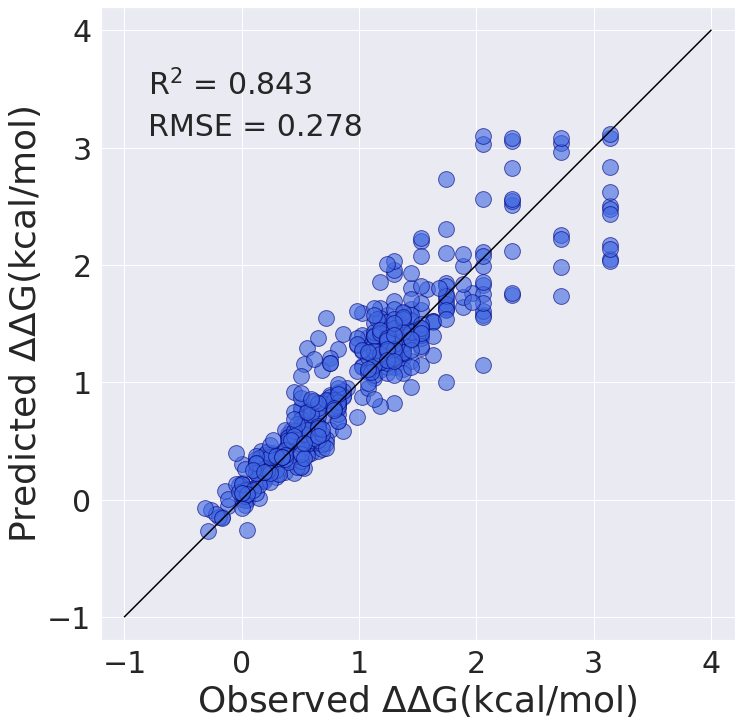

In [68]:
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt
sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',   
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')
plt.plot([-1,4],[-1,4],c='black')


plt.xlim(-1.2,4.2)
plt.ylim(-1.2,4.2)
x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(1)
ax=plt.gca()
#ax.set_facecolor('oldlace')
#ax.set_facecolor('')#oldlace   mistyrose
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed $\Delta$$\Delta$G(kcal/mol)",fontsize=36)
plt.ylabel("Predicted $\Delta$$\Delta$G(kcal/mol)",fontsize=36)
#plt.title('doyle',fontsize=14)
#plt.grid(c='white', linewidth=2)
plt.tick_params(labelsize=30)
plt.text(-0.8,3.1,'RMSE = %.3f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(-0.8,3.45,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()


## low to high

In [22]:
labels=np.array(labels)
ee = np.round((np.exp(labels*4184/(8.314*298.15)) - 1)/(np.exp(labels*4184/(8.314*298.15))+1),decimals=2)
low_data_index = np.where((ee<0.8))[0]
high_data_index = np.where((ee>=0.8))[0]
shuffle = list(range(len(high_data_index)))
np.random.shuffle(shuffle)
test_index = high_data_index[shuffle]
x_train=react_feat[low_data_index]
y_train=labels_std[low_data_index]
x_test= react_feat[test_index]
y_test=labels_std[test_index]

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
model = SPMSElecMulAttentionNN(184, 33, 19,depth=4,attention_depth=1,hidden_size=15,attention_depth_inter=1,inter_len=8,end_attention=1)
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,loss='mse')
checkpoint = tf.train.Checkpoint(myAwesomeModel=model)
EPOCHS = 100
for epoch in range(EPOCHS):
    hist = model.fit(x=x_train,y=y_train,validation_data=(x_test,y_test),batch_size=32)
    #predict=model.predict(x_test)
    #print(mean_squared_error(y_test,predict))
    path = checkpoint.save('./Denmark_DataSet/run_data/denmark_mulattention_low_basemodel.ckpt')
    print("model saved to %s" % path)

react_feat_mat (None, 236, 1)
react_feat_mat (None, 236)
react_feat_mat (None, 32)
super_feat (None, 1, 32)
react_feat_mat (None, None)
react_feat_mat_ (None, 236)
attention need (None, None)
react_feat_mat (None, 236, 1)
react_feat_mat (None, 236)
react_feat_mat (None, 32)
super_feat (None, 1, 32)
react_feat_mat (None, None)
react_feat_mat_ (None, 236)
attention need (None, None)
17/23 [=====================>........] - ETA: 0s - loss: 0.0324react_feat_mat (None, 236, 1)
react_feat_mat (None, 236)
react_feat_mat (None, 32)
super_feat (None, 1, 32)
react_feat_mat (None, None)
react_feat_mat_ (None, 236)
attention need (None, None)
23/23 [==============================] - 2s 26ms/step - loss: 0.0286 - val_loss: 0.1453
model saved to ./Denmark_DataSet/run_data/denmark_mulattention_low_basemodel.ckpt-1
23/23 [==============================] - 0s 9ms/step - loss: 0.0144 - val_loss: 0.1240
model saved to ./Denmark_DataSet/run_data/denmark_mulattention_low_basemodel.ckpt-2
23/23 [===========

23/23 [==============================] - 0s 9ms/step - loss: 6.9431e-04 - val_loss: 0.0234
model saved to ./Denmark_DataSet/run_data/denmark_mulattention_low_basemodel.ckpt-45
23/23 [==============================] - 0s 9ms/step - loss: 6.6214e-04 - val_loss: 0.0278
model saved to ./Denmark_DataSet/run_data/denmark_mulattention_low_basemodel.ckpt-46
23/23 [==============================] - 0s 9ms/step - loss: 5.9061e-04 - val_loss: 0.0252
model saved to ./Denmark_DataSet/run_data/denmark_mulattention_low_basemodel.ckpt-47
23/23 [==============================] - 0s 9ms/step - loss: 5.8699e-04 - val_loss: 0.0363
model saved to ./Denmark_DataSet/run_data/denmark_mulattention_low_basemodel.ckpt-48
23/23 [==============================] - 0s 9ms/step - loss: 5.9815e-04 - val_loss: 0.0244
model saved to ./Denmark_DataSet/run_data/denmark_mulattention_low_basemodel.ckpt-49
23/23 [==============================] - 0s 9ms/step - loss: 8.1541e-04 - val_loss: 0.0263
model saved to ./Denmark_Data

23/23 [==============================] - 0s 9ms/step - loss: 1.9480e-04 - val_loss: 0.0640
model saved to ./Denmark_DataSet/run_data/denmark_mulattention_low_basemodel.ckpt-92
23/23 [==============================] - 0s 9ms/step - loss: 1.7994e-04 - val_loss: 0.0858
model saved to ./Denmark_DataSet/run_data/denmark_mulattention_low_basemodel.ckpt-93
23/23 [==============================] - 0s 9ms/step - loss: 1.7996e-04 - val_loss: 0.0345
model saved to ./Denmark_DataSet/run_data/denmark_mulattention_low_basemodel.ckpt-94
23/23 [==============================] - 0s 9ms/step - loss: 1.8810e-04 - val_loss: 0.0380
model saved to ./Denmark_DataSet/run_data/denmark_mulattention_low_basemodel.ckpt-95
23/23 [==============================] - 0s 9ms/step - loss: 1.7071e-04 - val_loss: 0.0409
model saved to ./Denmark_DataSet/run_data/denmark_mulattention_low_basemodel.ckpt-96
23/23 [==============================] - 0s 9ms/step - loss: 1.9259e-04 - val_loss: 0.0453
model saved to ./Denmark_Data

In [38]:
opt = tf.keras.optimizers.Adam()
new_model =SPMSElecMulAttentionNN(184, 33, 19,depth=4,attention_depth=1,hidden_size=15,attention_depth_inter=1,inter_len=8,end_attention=1)
new_model.compile(optimizer=opt,loss='mse')
_ = new_model.fit(x=x_train,y=y_train,validation_data=(x_test,y_test),epochs=1)
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
checkpoint.restore('./Denmark_DataSet/run_data/denmark_mulattention_low_basemodel.ckpt-94')

react_feat_mat (None, 236, 1)
react_feat_mat (None, 236)
react_feat_mat (None, 32)
super_feat (None, 1, 32)
react_feat_mat (None, None)
react_feat_mat_ (None, 236)
attention need (None, None)
react_feat_mat (None, 236, 1)
react_feat_mat (None, 236)
react_feat_mat (None, 32)
super_feat (None, 1, 32)
react_feat_mat (None, None)
react_feat_mat_ (None, 236)
attention need (None, None)
17/23 [=====================>........] - ETA: 0s - loss: 0.0311react_feat_mat (None, 236, 1)
react_feat_mat (None, 236)
react_feat_mat (None, 32)
super_feat (None, 1, 32)
react_feat_mat (None, None)
react_feat_mat_ (None, 236)
attention need (None, None)
23/23 [==============================] - 2s 26ms/step - loss: 0.0273 - val_loss: 0.1253


In [39]:
y_test_pre=new_model.predict(x_test)
y_test_for_draw = y_test*(np.max(labels)-np.min(labels))+np.min(labels)
y_test_pred_for_draw = y_test_pre*(np.max(labels)-np.min(labels))+np.min(labels)
y_train_for_draw=y_train*(np.max(labels)-np.min(labels))+np.min(labels)
y_train_pred_for_draw=new_model.predict(x_train)*(np.max(labels)-np.min(labels))+np.min(labels)

react_feat_mat (None, 236, 1)
react_feat_mat (None, 236)
react_feat_mat (None, 32)
super_feat (None, 1, 32)
react_feat_mat (None, None)
react_feat_mat_ (None, 236)
attention need (None, None)


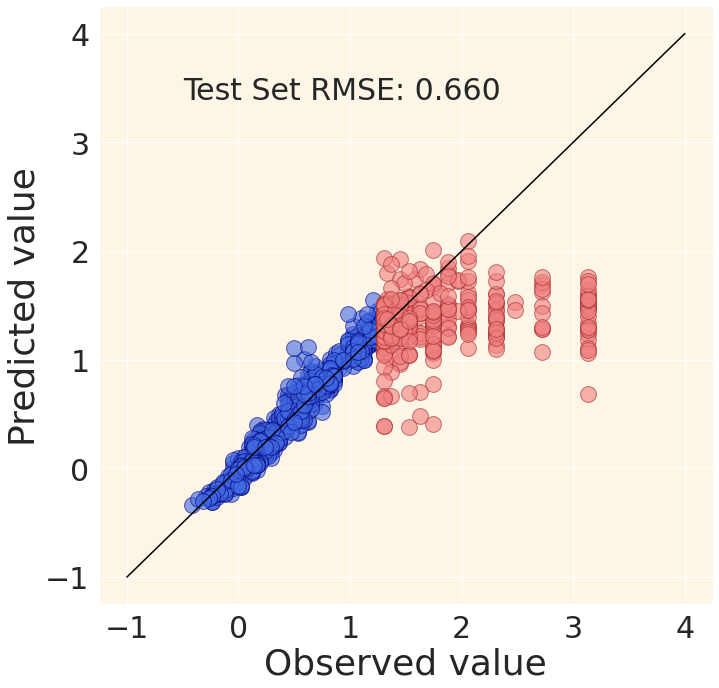

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
sns.set(style='darkgrid')


#display.set_matplotlib_formats('svg')
fig = plt.figure(figsize=(11,11),facecolor='white',    # 图表区的背景色
           edgecolor='black')
plt.scatter(y_train_for_draw,y_train_pred_for_draw,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')
plt.scatter(y_test_for_draw,y_test_pred_for_draw,s=250, c='lightcoral', label="samples",alpha=0.6,edgecolors='brown')
plt.plot([-1,4],[-1,4],c='black')
'''x = np.arange(-1,5)
y = x
l = plt.plot(x,y)
plt.xlim(-1,4)
plt.ylim(-1,4)
plt.fill_between(x,x+0.5,x-0.5,alpha=0.2,color='yellow')'''
#plt.title('doyle',fontsize=14)
ax=plt.gca()
ax.set_facecolor('oldlace')#oldlace   mistyrose
plt.xlabel("Observed value",fontsize=36)
plt.ylabel("Predicted value",fontsize=36)

#plt.grid(c='blue',linewidth=2)

plt.tick_params(labelsize=30)
plt.text(-0.5,3.4,'Test Set RMSE: %.3f'%(mean_squared_error(y_test_for_draw,y_test_pred_for_draw))**(0.5),fontsize=30)
#plt.text(-0.5,3.4,'Test Set R2: %.3f'%r2_score(y_test_for_draw,y_test_pred_for_draw),fontsize=24)
fig.savefig('./denmark_random_fig.png',dpi=400)
plt.show()

In [ ]:
y_test_pre=new_model.predict(x_test)
y_test_for_draw = y_test*(np.max(labels)-np.min(labels))+np.min(labels)
y_test_pred_for_draw = y_test_pre*(np.max(labels)-np.min(labels))+np.min(labels)
y_train_for_draw=y_train*(np.max(labels)-np.min(labels))+np.min(labels)
y_train_pred_for_draw=new_model.predict(x_train)*(np.max(labels)-np.min(labels))+np.min(labels)

In [42]:
np.save( './run_data/data2_mg_ignn_low_y_val.npy',y_test_for_draw)
np.save( './run_data/data2_mg_ignn_low_y_val_pred.npy',y_test_pred_for_draw)
np.save( './run_data/data2_mg_ignn_low_y_train.npy',y_train_for_draw)
np.save( './run_data/data2_mg_ignn_low_y_train_pred.npy',y_train_pred_for_draw)